In [55]:
# from keras.datasets import mnist
import numpy as np
# from jaw_gen import *

from keras.layers import Input, Dense, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model

import keras.backend as K
from keras.layers import Lambda
import cv2



In [56]:
# класс для создания картинок обучающей выборки
red = (0, 0, 255)
white = (255, 255, 255)

# print(f" cv2 ver. {cv2.__version__}, np ver. {np.__version__}")
np.random.seed() # устанавливает режим случайных чисел без повторений от запуска к запуску

class landmark_gen():
    ''' creates pictures with incistor edges landmarks '''

    def __init__(self, number=1000, dim=(200, 200), x_axes=(-10, 10), y_axes=(-200, 10)):
        self.number = number
        self.dim = dim
        self.x_axes = x_axes
        self.y_axes = y_axes

    def image_gen(self, name='_', scale1=14, factor=2.6, shift_x=0, shift_y=0, show=False):
        # встроить сюда еще смещение 
        self.back = np.zeros(self.dim)
        self.factor = factor
        center = (int(self.dim[0]/2), int(self.dim[1]/2))

        # оси координат по центру
        cv2.line(self.back, (0, center[1]), (self.dim[0], center[1]), 0.4, 1)
        cv2.line(self.back, (center[0], 0), (center[0], self.dim[1]), 0.4, 1)

        # строим дугу. так чтобы на основе ее точек можно было
        for i in range(-8, 8):
            # строим точки графика
            # point_ = int(i*15+0.2)+center[0], int(self.duga(i-0.2)) + center[1]
            point_ = int(i*scale1)+center[0], int(self.duga(i)) + center[1]
            point2_ = int((i+1-0.2)*scale1 +
                          center[0]), int(self.duga(i+1-0.2)) + center[1]

            # cv2.circle(self.back, point_, 1, 0.2, 1)

            # строим линии между точками
            cv2.line(self.back, point_, point2_, 1, 2)

        if show:
            cv2.imshow(name, self.back)
            k = cv2.waitKey()

        return self.back

    def duga(self, x):
        ''' returns arc function'''
        return abs(x)**self.factor - self. dim[1]*0.35


In [57]:
# заготовим новый дата это сет из зубьев.
# класс landmark_gen генерит картинки по одной
# сделаем набор и побьем его на 2 части train и test. Метки не нужны
data_set_len = 1280
# a = [None for i in range(data_set_len)]
data_set=[]


# 10k картинок генерится примерно 15сек
for i in range(data_set_len):
    # параметр влияяет на ширину дуги
    scale = 9 + np.random.sample()*3        # диапазон от 14 до 19
    # параметр влияет на длину дуги
    factor = 2.2 + np.random.sample()/5     # диапазон 2.5 - 2.7
        
    # a[i] = landmark_gen(number=data_set_len).image_gen(scale1=scale, factor=factor)
    # это жуть как странно но append работает быстрее. надо с этим разобраться
    data_set.append(landmark_gen(number=data_set_len).image_gen(scale1=scale, factor=factor))

print (f"len a = {len(data_set)}")

# поделим весь на сет в соотношении 80-20% для тренировки и теста
train_len = round(data_set_len*0.8)

# npa = np.asarray(someListOfLists, dtype=np.float32)

x_train = np.asarray(data_set[:train_len], dtype=np.float32)
x_test = np.asarray(data_set[train_len:], dtype=np.float32)

print (f"len x_train - {len(x_train)}  len x_test - {len(x_test)}")


len a = 1280
len x_train - 1024  len x_test - 256


In [58]:
# x_train = x_train.astype('float32') / 255.
x_train = x_train / 255.
# x_test  = x_test .astype('float32') / 255.
x_test  = x_test / 255.
x_train = np.reshape(x_train, (len(x_train), 200, 200, 1))
x_test  = np.reshape(x_test,  (len(x_test),  200, 200, 1))

In [59]:
def create_dense_ae():
    # Размерность кодированного представления
    encoding_dim = 3000

    # Энкодер
    # Входной плейсхолдер
    input_img = Input(shape=(200, 200, 1)) # 28, 28, 1 - размерности строк, столбцов, фильтров одной картинки, без батч-размерности
    # Вспомогательный слой решейпинга
    flat_img = Flatten()(input_img)
    # Кодированное полносвязным слоем представление
    encoded = Dense(encoding_dim, activation='relu')(flat_img)
    
    # Декодер
    # Раскодированное другим полносвязным слоем изображение
    input_encoded = Input(shape=(encoding_dim,))
    flat_decoded = Dense(200*200, activation='sigmoid')(input_encoded)
    decoded = Reshape((200, 200, 1))(flat_decoded)

    # Модели, в конструктор первым аргументом передаются входные слои, а вторым выходные слои
    # Другие модели можно так же использовать как и слои
    encoder = Model(input_img, encoded, name="encoder")
    decoder = Model(input_encoded, decoded, name="decoder")
    autoencoder = Model(input_img, decoder(encoder(input_img)), name="autoencoder")
    return encoder, decoder, autoencoder

In [60]:
encoder, decoder, autoencoder = create_dense_ae()
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [61]:
batch_size = 128

def create_denoising_model(autoencoder):
    def add_noise(x):
        noise_factor = 0.5
        # x = x + K.random_normal(x.get_shape(), 0.5, noise_factor)
        x = K.clip(x, 0., 1.)
        return x

    input_img  = Input(batch_shape=(batch_size, 200, 200, 1))
    noised_img = Lambda(add_noise)(input_img)

    noiser = Model(input_img, noised_img, name="noiser")
    denoiser_model = Model(input_img, autoencoder(noiser(input_img)), name="denoiser")
    return noiser, denoiser_model


noiser, denoiser_model = create_denoising_model(autoencoder)
denoiser_model.compile(optimizer='adam', loss='binary_crossentropy')

In [62]:
history = denoiser_model.fit(x_train, x_train,
                   epochs=50,
                   batch_size=batch_size,
                   shuffle=True,
                   validation_data=(x_test, x_test))

print('\nhistory dict:', history.history)

Epoch 1/50
8/8 [==============================] - 29s 3s/step - loss: 0.6915 - val_loss: 0.6889
Epoch 2/50
8/8 [==============================] - 19s 2s/step - loss: 0.6847 - val_loss: 0.6760
Epoch 3/50
8/8 [==============================] - 17s 2s/step - loss: 0.6585 - val_loss: 0.6227
Epoch 4/50
8/8 [==============================] - 19s 2s/step - loss: 0.5649 - val_loss: 0.4640
Epoch 5/50
8/8 [==============================] - 19s 2s/step - loss: 0.3582 - val_loss: 0.2162
Epoch 6/50
8/8 [==============================] - 15s 2s/step - loss: 0.1382 - val_loss: 0.0616
Epoch 7/50
8/8 [==============================] - 15s 2s/step - loss: 0.0385 - val_loss: 0.0180
Epoch 8/50
8/8 [==============================] - 16s 2s/step - loss: 0.0130 - val_loss: 0.0078
Epoch 9/50
8/8 [==============================] - 16s 2s/step - loss: 0.0065 - val_loss: 0.0047
Epoch 10/50
8/8 [==============================] - 17s 2s/step - loss: 0.0043 - val_loss: 0.0036
Epoch 11/50
8/8 [======================

In [63]:
denoiser_model.save('denoiser_model.h5')  

In [64]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

def plot_digits(*args):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    
    plt.figure(figsize=(2*n, 2*len(args)))
    for j in range(n):
        for i in range(len(args)):
            ax = plt.subplot(len(args), n, i*n + j + 1)
            plt.imshow(args[i][j])
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    plt.show()

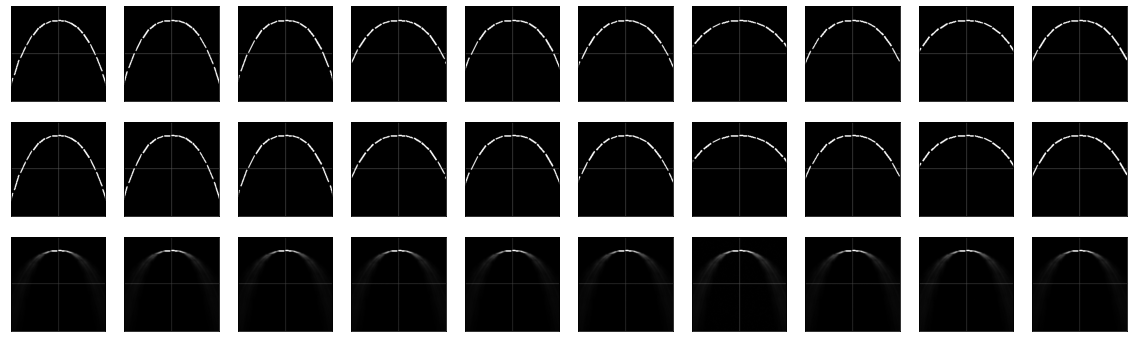

In [65]:
n = 10

imgs = x_test[:batch_size]
noised_imgs = noiser.predict(imgs, batch_size=batch_size)
encoded_imgs = encoder.predict(noised_imgs[:n],  batch_size=n)
decoded_imgs = decoder.predict(encoded_imgs[:n], batch_size=n)

plot_digits(imgs[:n], noised_imgs, decoded_imgs)

In [66]:
# посмотрим кодированные имаги
encoded_imgs[:100]

array([[0.22348212, 0.22756371, 0.        , ..., 0.2304014 , 0.23047501,
        0.        ],
       [0.22363399, 0.22877915, 0.        , ..., 0.23051187, 0.22901401,
        0.        ],
       [0.22189264, 0.22667544, 0.        , ..., 0.22826082, 0.22698167,
        0.        ],
       ...,
       [0.21386227, 0.21763112, 0.        , ..., 0.22080997, 0.21865419,
        0.        ],
       [0.19137391, 0.19404891, 0.        , ..., 0.19821022, 0.19662212,
        0.        ],
       [0.22009364, 0.22336239, 0.        , ..., 0.22724158, 0.22489876,
        0.        ]], dtype=float32)